# Time to Design some circuits #

First of all, we need to install qiskit. On the previous notebook we ran !pip install qiskit and that should do.

Furthermore, we need to register on the IBM Quantum Experience website if we want to run our experiments on actual quantum machines and not just a simulator. You can register an account here: https://quantum-computing.ibm.com/

# Entanglement #

We want somehow to capture the notion of 'twin' qubits. That is, we want a way to generate 2 qubits and guarantee that when one is measured and is assigned a value, the other one will be assigned the same value as well.

Entanglement is kind of a crazy thing, more information from reliable sources can be found here: https://en.wikipedia.org/wiki/Quantum_entanglement

Let's first define the 2 qubits.

In [45]:
!pip install -U qiskit
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

Requirement already up-to-date: qiskit in c:\users\infinity\anaconda3\lib\site-packages (0.23.0)


In [2]:
qr = QuantumRegister( 2 )
cr = ClassicalRegister( 2 )

In [3]:
circuit = QuantumCircuit( qr, cr ) 
%matplotlib inline
circuit.draw()

q0_0: 
      
q0_1: 
      
c0: 2/

# So far so good #

We have implemented an empty circuit with 2 quantum and two classical bits. Let's do some magic.

In [4]:
circuit.h(qr[ 0 ])
circuit.draw()

┌───┐
q0_0: ┤ H ├
      └───┘
q0_1: ─────
           
c0: 2/═════

In [5]:
circuit.cx( qr[ 0 ], qr[ 1 ] )
circuit.draw()

┌───┐     
q0_0: ┤ H ├──■──
      └───┘┌─┴─┐
q0_1: ─────┤ X ├
           └───┘
c0: 2/══════════

In [6]:
circuit.measure( qr, cr )
circuit.draw()

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1

# Why though? #

Alright, let's see what we have so far. Let's think of the first half of the circuit. Suppose we have a qubit that is either in state 0 or 1. Without loss of generality suppose the first qubit is: $q_0 = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$. By applying the Hadamard gate we get $H(q_0)= \begin{pmatrix} \frac{1}{\sqrt(2)} \\ \frac{1}{\sqrt(2)} \end{pmatrix}$

Now we want to apply the Controlled X gate. How? Shut up and calculate.

$C_x \begin{pmatrix} \frac{1}{\sqrt(2)} \\ \frac{1}{\sqrt(2)} \end{pmatrix} \otimes \begin{pmatrix} 1 \\ 0 \end{pmatrix} = C_x \begin{pmatrix} \frac{1}{\sqrt(2)} \\ 0 \\ \frac{1}{\sqrt{2}} \\ 0  \end{pmatrix} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix} \begin{pmatrix} \frac{1}{\sqrt(2)} \\ 0 \\ \frac{1}{\sqrt{2}} \\ 0  \end{pmatrix} = \begin{pmatrix} \frac{1}{\sqrt(2)} \\ 0 \\ 0 \\ \frac{1}{\sqrt{2}}  \end{pmatrix}$

That is, this quantum state collapses to 00 with probability 1/2 and to 11 with probability 1/2. We cannot have states 01 or 10.

In [7]:
def transform( operator, state ):
    return np.array( operator ).dot( state )

def hadamard( state ):
    operator = [ [ 1/sqrt(2), 1/sqrt(2) ], 
                 [ 1/sqrt(2), -1/sqrt(2) ] ]
    return transform( operator, state )

def cnot( state ):
    operator = [ [ 1, 0, 0, 0 ],
                 [ 0, 1, 0, 0 ],
                 [ 0, 0, 0, 1 ],
                 [ 0, 0, 1, 0 ] ]
    return transform( operator, state )

def tensor_dot( state1, state2 ):
    product = []
    for x in state1:
        for y in state2:
            product.append( x * y )
    return product

q0 = [ 1, 0 ]
q0 = hadamard( q0 )
print( "first qubit: ", q0 )
q1 = [ 1, 0 ]
state = tensor_dot( q0, q1 )
print( "state: ", state )
res = cnot( state )
print("state of the circuit: ", res )

first qubit:  [0.70710678 0.70710678]
state:  [0.7071067811865475, 0.0, 0.7071067811865475, 0.0]
state of the circuit:  [0.70710678 0.         0.         0.70710678]


Therefore we can see computationally what we have already proven. Let's try to test this hypothesis using the actual quantum circuit.

In [8]:
backend = Aer.get_backend('qasm_simulator')
result = execute( circuit, backend = backend, shots = 100 ).result()

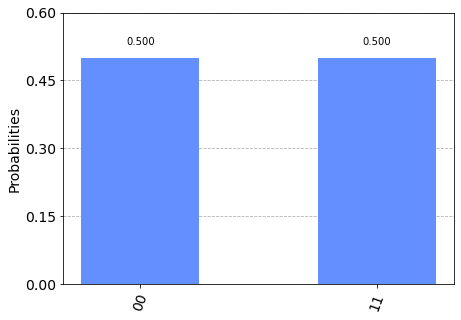

In [9]:
#Visualize results
plot_histogram( result.get_counts( circuit ) )

# How about some real fun? #

Let's try and run our already made circuit on an actual quantum machine. We will use the IBM Quantum Experience API.

First we need to load our account using our access token.

In [46]:
token = open("token.txt").read()
IBMQ.save_account( token )
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

configrc.store_credentials:WARNING:2020-10-27 16:24:40,943: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2020-10-27 16:24:41,874: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
quantum_computer = provider.get_backend('ibmq_athens')
experiment = execute( circuit, backend = quantum_computer )

In [12]:
job_monitor( experiment )

Job Status: job has successfully run


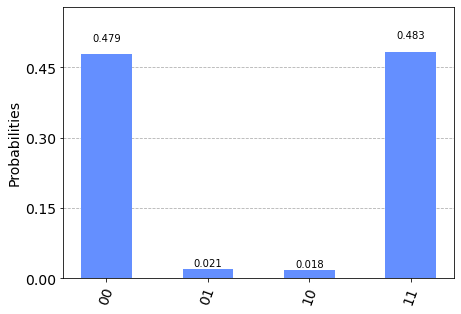

In [13]:
result = experiment.result()
plot_histogram( result.get_counts( circuit ) )

# YOU LIED TO US #

We can see that even though we spent a fair amount of time arguing that states 01 and 10 are not allowed in our circuit there are some results that indicate otherwise.

This is due to the current state of quantum technology. The quantum systems are very noisy in general and therefore prone to errors.

# Quantum Teleportation #

In a classical computational setting i.e Python, C++, copying the value of a variable is literally as easy as it gets.

a = 5, b = a

In a quantum computer though where the registers contain a quantum state this is not so easy. In order to copy the value of a register we are implicitly doing a measurement and therefore we are destroying the quantum state.

We need a way to copy the state of a quantum register onto another. This is done using Quantum Teleportation.

# Some Setup#

Suppose we need to teleport a quantum state of: $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ (that is the state of 0) to some other qubit. Notice that this is not binding, we can teleport any quantum state but by teleporting a simple one it's easier to test our results.

First of all we need to define a 3 qubit Quantum Register and a 3 bit Classical Register and set one qubit to the state $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$

In [47]:
qr = QuantumRegister( 3 )
cr = ClassicalRegister( 3 )
circuit = QuantumCircuit( qr, cr ) 
%matplotlib inline
circuit.draw()

q42_0: 
       
q42_1: 
       
q42_2: 
       
c11: 3/

In [48]:
circuit.h(1)
circuit.cx(1,2)
circuit.cx( 0, 1 )
circuit.h( 0 )
circuit.barrier()
circuit.measure( [0, 1 ], [ 0, 1 ] )
circuit.barrier()
circuit.cx( 1,2 )
circuit.cz( 0, 2)
circuit.draw()

┌───┐          ┌───┐ ░ ┌─┐    ░         
q42_0: ┤ X ├───────■──┤ H ├─░─┤M├────░───────■─
       ├───┤     ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░       │ 
q42_1: ┤ H ├──■──┤ X ├──────░──╫─┤M├─░───■───┼─
       └───┘┌─┴─┐└───┘      ░  ║ └╥┘ ░ ┌─┴─┐ │ 
q42_2: ─────┤ X ├───────────░──╫──╫──░─┤ X ├─■─
            └───┘           ░  ║  ║  ░ └───┘   
c11: 3/════════════════════════╩══╩════════════
                               0  1

Alright, this is kinda crazy, what we claim though is that  the state of qubit 0 (which is $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$) has been transfered to qubit 2. 

That is qubit 2 will always be 0 no matter how many times it gets measured.

Let's run an experiment.

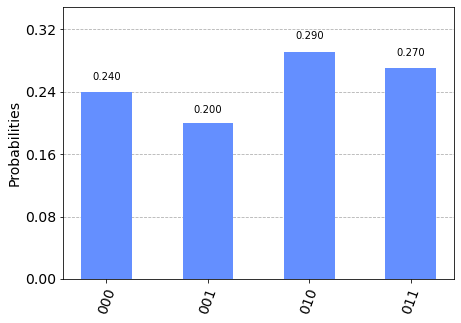

In [49]:
backend = Aer.get_backend('qasm_simulator')
result = execute( circuit, backend = backend, shots = 100 ).result()
plot_histogram( result.get_counts( circuit ) )

# Let's do it on a quantum computer#

In [50]:
quantum_computer = provider.get_backend('ibmq_athens')
experiment = execute( circuit, backend = quantum_computer )

In [ ]:
job_monitor( experiment )

Job Status: job is queued (13)

In [ ]:
result = experiment.result()
plot_histogram( result.get_counts( circuit ) )